In [125]:
%matplotlib inline  

from sklearn.datasets import fetch_mldata
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import *
from scipy.ndimage import convolve

In [126]:
mnist = fetch_mldata("MNIST original")
# rescale the data, use the traditional train/test split
X, y = mnist.data / 255., mnist.target

X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]


In [127]:
def imShow(pixels, label):
    plt.title('label: {l}'.format(l = label))
    plt.imshow(pixels.reshape((28, 28)), cmap='gray', vmin=0, vmax=1)

In [128]:
layerSizes = np.array([784,45,10])
model = MLPClassifier(hidden_layer_sizes=tuple(layerSizes[1:-1]), activation='relu', alpha=1e-4,
                      solver='sgd', verbose=5, tol=1e-4, random_state=1)

model.fit(X_train, y_train)

print("Training set score: %f" % model.score(X_train, y_train))
print("Test set score: %f" % model.score(X_test, y_test))

Iteration 1, loss = 1.58663232
Iteration 2, loss = 0.77736467
Iteration 3, loss = 0.56838930
Iteration 4, loss = 0.48369756
Iteration 5, loss = 0.43733282
Iteration 6, loss = 0.40741608
Iteration 7, loss = 0.38615539
Iteration 8, loss = 0.37002805
Iteration 9, loss = 0.35731226
Iteration 10, loss = 0.34654333
Iteration 11, loss = 0.33739517
Iteration 12, loss = 0.32952977
Iteration 13, loss = 0.32250764
Iteration 14, loss = 0.31632009
Iteration 15, loss = 0.31056912
Iteration 16, loss = 0.30528237
Iteration 17, loss = 0.30044212
Iteration 18, loss = 0.29590071
Iteration 19, loss = 0.29164408
Iteration 20, loss = 0.28772777
Iteration 21, loss = 0.28362797
Iteration 22, loss = 0.27997125
Iteration 23, loss = 0.27641876
Iteration 24, loss = 0.27294406
Iteration 25, loss = 0.26960793
Iteration 26, loss = 0.26653992
Iteration 27, loss = 0.26329658
Iteration 28, loss = 0.26027984
Iteration 29, loss = 0.25721625
Iteration 30, loss = 0.25429795
Iteration 31, loss = 0.25148237
Iteration 32, los

C:\Program Files\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Training set score: 0.973400
Test set score: 0.965600


In [129]:
index_training = 51000;
label = int(y_train[index_training])

xIn = X_train[index_training]

def run(m, seed):
    inputs = []
    #setup inputs & disturbance
    disturbance = []
    disturbanceAbs = []
    for i in range(len(xIn)):
        e = m.addVar(vtype=GRB.CONTINUOUS, name ="disturbance" + str(i))
        a = m.addVar(vtype=GRB.CONTINUOUS, name ="disturbanceAbs" + str(i))

        m.addConstr(a == abs_(e))  #abs

        m.addConstr(e + xIn[i] >= 0)
        m.addConstr(e + xIn[i] <= 1)

        disturbance.append(e)
        disturbanceAbs.append(a)
        inputs.append(e + xIn[i])

    #calculate extreme values for M definition
    #extremeValues = list(map(lambda i: [0,1], range(len(xIn))))
    mValues = []

    #setup constraints for reLu
    for lIndex in range(len(layerSizes)-1):
        inCnt = layerSizes[lIndex]
        outCnt = layerSizes[lIndex+1]
        layer = []
        tmpExtremeValues = []

        for nIndex in range(outCnt):
            b = m.addVar(vtype=GRB.BINARY, name="b_{0}_{1}".format(lIndex,nIndex))
            x = m.addVar(vtype=GRB.CONTINUOUS, name="x_{0}_{1}".format(lIndex,nIndex))
            imVar = m.addVar(vtype=GRB.CONTINUOUS, name="imVar_{0}_{1}".format(lIndex,nIndex))
            
            im = LinExpr()

            #weights
            for i in range(inCnt):
                weight = model.coefs_[lIndex][i][nIndex]
                im.add(inputs[i]*weight)

            #bias weight
            im.add(model.intercepts_[lIndex][nIndex])
            m.addGenConstrMax(x, [imVar], 0)

            m.addConstr(x >= 0)
            m.addConstr(x >= im)        
            
            m.addConstr((b == 0) >> (x == 0))
            m.addConstr((b == 1) >> (x == im))

            layer.append(x)
        inputs = layer
        #extremeValues = tmpExtremeValues

    outVars = inputs
    n = 1
    #output constraints (given label must be lower than n others)
    outBinVars = []
    for i in range(10):
        if i != label:
            binVar = m.addVar(vtype=GRB.BINARY, name ="outBin" + str(i))
            outBinVars.append(binVar)
            m.addConstr((binVar == 1) >> (outVars[i] >= outVars[label]))
            #m.addConstr(outVars[label] * binVar <= outVars[i])
    
    # all binVars are 0 expect n
    #m.addConstr(quicksum(outBinVars) == n)
    m.addGenConstrOr(m.addVar(vtype=GRB.BINARY, ub=1, lb=1), outBinVars);
    m.setObjective(quicksum(disturbanceAbs), GRB.MINIMIZE)
    m.params.Seed = seed
    m.optimize()
    return disturbance

In [130]:
secs = 0;
n = 3
disturbance = [];
for i in range(n):
    m = Model("mip1")
    disturbance = run(m, i)
    #print(m.Runtime)
    secs = secs + m.Runtime


    

Parameter Seed unchanged
   Value: 0  Min: 0  Max: 2000000000  Default: 0
Optimize a model with 1678 rows, 1743 columns and 37408 nonzeros
Model has 959 general constraints
Variable types: 1678 continuous, 65 integer (65 binary)
Coefficient statistics:
  Matrix range     [2e-07, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 5e+00]
Presolve removed 1269 rows and 614 columns
Presolve time: 0.17s
Presolved: 409 rows, 1129 columns, 71969 nonzeros
Presolved model has 9 SOS constraint(s)
Variable types: 900 continuous, 229 integer (229 binary)

Root relaxation: objective 0.000000e+00, 196 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    4          -    0.00000      -     -    0s
H    0     0                       8.8407207    0.00000   100%     -    0s
     0     0    0.00000    

 56254  8965    4.60101   34   10    8.39888    4.57398  45.5%  11.0   40s
 66339 10413    8.26188   48    6    8.39888    4.85882  42.1%  10.8   45s
 75176 11565     cutoff   31         8.39888    5.10130  39.3%  10.5   50s
 84810 12078    5.36951   27    6    8.39888    5.36951  36.1%  10.4   55s
 94154 12774    6.29116   49    3    8.39888    5.61584  33.1%  10.2   60s
 103574 13045     cutoff   47         8.39888    5.86339  30.2%  10.1   65s
 111323 13349    6.01990   42    1    8.39888    6.01990  28.3%  10.0   70s
 120937 13599     cutoff   49         8.39888    6.19915  26.2%   9.8   75s
 131079 13855    6.38155   49    3    8.39888    6.38155  24.0%   9.5   80s
 141063 14047     cutoff   39         8.39888    6.58607  21.6%   9.3   85s
 151207 13794    6.77575   49    2    8.39888    6.77575  19.3%   9.1   90s
 160471 13589     cutoff   48         8.39888    6.92667  17.5%   9.0   95s
 170677 13169    7.13128   30   16    8.39888    7.09325  15.5%   8.8  100s
 181299 12614    

In [131]:
print(secs/n)

110.68332926432292


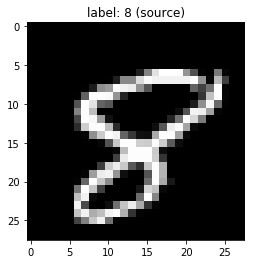

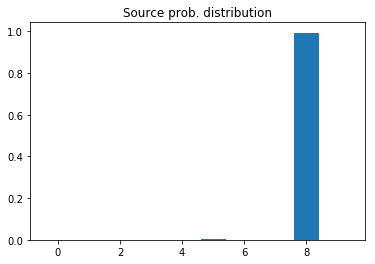

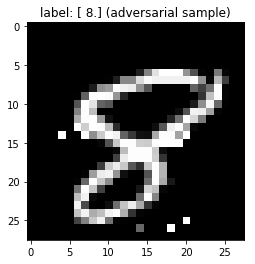

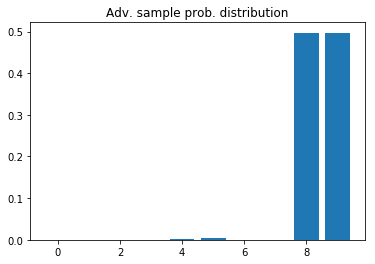

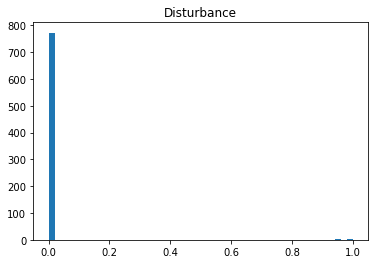

array([  1.66421031e-04,   3.22708624e-07,   1.73719659e-05,
         2.40267104e-04,   1.14189132e-03,   3.59780574e-03,
         3.04161374e-05,   4.27165210e-04,   4.97189169e-01,
         4.97189169e-01])

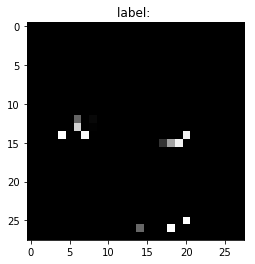

In [132]:
imShow(xIn, str(label) + " (source)")
plt.show()
plt.bar(range(10),model.predict_proba(xIn.reshape(1, -1))[0])
plt.title('Source prob. distribution')
plt.show()
sample = np.array(list(map(lambda i:xIn[i] + disturbance[i].X, range(len(xIn))))) 
falseLabel = model.predict(sample.reshape(1, -1))
imShow(sample, str(falseLabel) + " (adversarial sample)")
plt.show()
plt.bar(range(10),model.predict_proba(sample.reshape(1, -1))[0])
plt.title('Adv. sample prob. distribution')
plt.show()
 
d = np.array(list(map(lambda i:disturbance[i].X, range(len(xIn)))))
plt.hist(d,bins=50)
plt.title('Disturbance')
plt.show()
imShow(d,"")
model.predict_proba(sample.reshape(1, -1))[0]